<a href="https://colab.research.google.com/github/gatherheart/Classification_With_BERT/blob/main/bert_news_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<br>
<br>

# **Preparation**

In [ ]:
# Hugging Face의 트랜스포머 모델을 설치
!pip install transformers

     |████████████████████████████████| 1.3MB 13.4MB/s 
     |████████████████████████████████| 1.1MB 45.6MB/s 
     |████████████████████████████████| 2.9MB 67.0MB/s 
     |████████████████████████████████| 890kB 64.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=39a740f64ab3a3934907b2f4bfbbd24801d6cc5f25f3e8252cf2ff6fa2c7e33a
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
BASE_URL = '/content/drive/MyDrive/hu_dataset'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Nov 30 04:58:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    23W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
import time
import datetime

<br>
<br>

# **Data Load**

In [ ]:
df = pd.read_csv(BASE_URL+'/preprocessed_data.csv', index_col=[0])

In [ ]:
labels_csv = pd.read_csv('/content/drive/MyDrive/hu_dataset/labels_dict.csv', index_col=[0])

In [ ]:
df.columns

Index(['일자', '제목', '통합 분류1', '키워드', '특성추출(가중치순 상위 50개)', '본문', 'label'], dtype='object')

In [ ]:
df = df[['키워드', '본문', '특성추출(가중치순 상위 50개)', 'label']]

In [ ]:
df.head(n=10)

,키워드,본문,특성추출(가중치순 상위 50개),label
0,"페놀,도시,도시,국회의원,강효상,자유,한국당,비례,대구,달서병,당협,위원장,물클러스...","물클러스터'물기술인증원 잇단 유치 \n대구, 대한민국 물산업 전진기지로 \n \n ...",대구 물산업클러스터 물산업 클러스터 기업인 환경부 물기술인증원 강효상 수돗물 대한민...,0
1,"판소리,흥보,정기발표회,명창,정순임,정기,표회,서라벌문화관,경주,판소리,예능,보유자...",판소리 예능보유자인 정순임 명창이 12월 11일(수) 오후 7시 경주 서라벌문화회관...,판소리 정순임 흥보 경상북도 발표회 이수자 경주 남도 제비노정기 정기발표회 문화재 ...,1
2,"정보통신산업진흥원,ICT,콤플렉스,개소,역할,미래,ICT,혁신,인재,선도,기업,성장...",미래를 이끌어갈 ICT 혁신인재와 선도적 기업으로의 성장을 지원하는 SW개발공간 제...,ict콤플렉스 ict 4차 sw 해커톤 100건 베트남 마포구 마포청년혁신타운 서울...,2
3,"지원시,대입,정시,지원,사항,전형,마무리,수시모집,합격,학생들,정시모집,집중,이틀,...",이제 모든 수시 전형이 마무리가 되었을 것이다. 수시모집에서 합격하지 못한 학생들은...,서울대 표준점수 백분위 대학별 100점 대구진학지도협의회 상위권 학생들 고려대 서강...,3
4,"경상고,개최,유교,책판,순회,전시회,대구,경상고등학교,교장,이철우,교내,강당,유교,...",대구 경상고등학교(교장 이철우)가 최근 교내 강당에서 '찾아가는 유교 책판 순회 전...,전시회 복원본 이철우 무구정광대다라니경 경상고 세계기록유산 책판 도산서당 이원호 유...,4
5,"남편,무하마드,단풍,경북,영양,심심산골,그림,운무,염소들,산책,시작,골짜기,염소들,...",단풍이 물들어가는 경북 영양의 심심산골. 그림 같은 운무가 걷히면 염소들의 산책이 ...,현민씨 한국 화선씨 무하마드 파키스탄 마산 현민 박현민 염소들 장모님 닭살부부 아미...,5
6,"극한직업,장애인,취준,취업,방송,별일,극한직업,주제,재치,진행,MC,조우종,이동우,...",2일 방송되는 <별일 없이 산다>에서는 ‘극한직업’이라는 주제를 놓고 재치 넘치는 ...,장애인 홍서윤 극한직업 이상미 조우종 이계천 별일 desk 사람들 직업관 김동구 옛...,6
7,"대구미래,여성,이야기,영화데이,개최,대구미래,여성,대표,오무선,이야기,영화데이,4일...",(사)대구미래인여성(대표 오무선)은 제6회 '이야기가 있는 영화데이'를 4일(수) ...,긴즈버그 동국대 차세대 대백프라자 하버드대학교 변호인 영화데이 대구미래 수석졸업생 ...,7
8,"무관심,남화영,경북,소방본,부장,날씨,동시,화재,발생,증가,추세,소방관서,겨울철,소...",날씨가 추워지면서 자연스레 불을 가까이 하는 시기가 다가와 동시에 화재 발생도 증가...,겨울철 부주의 경북 소방력 경북소방본부 소방관서 일상생활 무각본 남화영 무관심 소방...,8
9,"다문화,가족,교류,소통,공간,개소,국가,전통,음식,비치,각국,도서,대구,동구청,다문...",대구 동구청은 다문화가족의 교류소통공간인 '다가온'(ON)이 최근 문을 열었다고 1...,베트남 각국 다문화가족 다문화 교류소통공간 동구 편의시설 체험프로그램 전통음식 7천...,0


In [ ]:
df[df['label']==10]

,키워드,본문,특성추출(가중치순 상위 50개),label
11,"괴담,연예,재현,프로듀스,사건,시즌,조작,카라,멤버,구하라,사건,한동안,괴담,연예,...",프로듀스 101 전 시즌 조작 사건과 '카라'의 전 멤버 구하라가 갑작스레 숨진 사...,연예계 교통사고 연예인 사건들 강병철 듀스 호기심 연예인들 듯이 김호영,10
31,"2019년,월30일,12월,음력11월,4일,11월,장기,관점,계획,48세,참견,상생...",◇쥐 \n \n ▲36세 장기적인 관점에서 계획을 세우는 것이 필요한 시기. ▲48...,흉일 길일 만큼 눈앞 인덕 아랫사람 참이름 결단력 56세 72세 53세 64세 걱정...,10
76,"생생정보,무한리필,모둠전,꼬치전,동그랑땡,묵사발,침샘자극,생생정보,모둠전,무한리필,...",‘생생정보’ 7000원 모둠전 무한리필 맛집이 주목을 받았다. \n\n28일 오후 ...,모둠전 동그랑땡 생생정보 주인장 kbs2 꼬치전 무한리필 남동구 침샘자극 리얼가 동...,10
99,"1500년,비화가야,무덤,63호,창녕,고분,일반,공개,추정,최고,지배자,무덤,도굴,...",창녕 고분군 63호분 일반 공개 5세기 최고 지배자 무덤 추정\n도굴 없이 온전한 ...,비화가야 63호 39호 연구소 뚜껑돌 창녕 매장주체부 고분군 경북 교동 송현동 주체...,10
181,"단국대,동창회,신석주,거보산업,대표,자랑,단국인,선정,단국대,동창회,회장,윤석기,신...",단국대 총동창회(회장 윤석기)는 신석주 (주)거보산업 대표이사를 올해의 자랑스러운 ...,동창회 신석주 더케이호텔서울 거보산업 동문회 시상식 건설환경전문기업 윤석기 단국대 ...,10
...,...,...,...,...
59186,"코로나19,취약계층,김장김치,온정,제공,사진,농협,농협,회장,이성희,경제지주,서울광...",사진 농협 제공 \n농협(회장 이성희) 경제지주가 24일 서울 도봉구 소재 서울광역...,농협 서울 코로나19 5000포기 국민운동 이성희 사회취약계층 취약계층 경제지주 사...,10
59191,"대우조선,선박,제공,사진,대우조선해양,대우조선해양,대표이사,이성근,건조,LNG운반선...",사진 대우조선해양 제공 \n대우조선해양(대표이사 이성근)은 건조 중인 LNG운반선에...,대우조선해양 이성근 천연가스 lng 대표이사 운반선 옥포조선소 조선업 선적작업 ln...,10
59596,"7시간,사랑,제일교회,명도,집행,중단,10여,부상,장위동,서울,성북구,사랑제일교회,...",서울 성북구 장위동의 사랑제일교회에 대한 법원의 명도집행이 신도들의 저항에 부딪혀 ...,서울 신도 10여 사랑제일교회 명도집행 성북구 제일교회 부상자 소방당국 화염병 장위...,10
59753,"재정난,순복음교회,알짜,여의도,알짜,매물,여의도순복음교회,소유,서울,여의도,금싸라기...",[아시아경제 문제원 기자] 여의도순복음교회 소유 서울 여의도의 8264㎡짜리 금싸라...,여의도 코로나19 여의도순복음교회 관계자 학교용지 신도 서울 부동산 금호리첸시아 순...,10


In [ ]:
print(set(df['label']))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84}


In [ ]:
NUM_LABELS = max(set(df['label'])) + 1

In [ ]:
NUM_LABELS

85

In [ ]:
text_to_label = dict(labels_csv)

In [ ]:
int(text_to_label['IT_과학>IT_과학일반'])

53

In [ ]:
label_to_text = {}
for label in text_to_label:
    label_to_text[int(text_to_label[label])] = label

In [ ]:
label_to_text

{0: '지역>대구',
 1: '문화>음악',
 2: '경제>취업_창업',
 3: '사회>교육_시험',
 4: '문화>전시_공연',
 5: '문화>방송_연예',
 6: '사회>장애인',
 7: '사회>여성',
 8: '지역>대전',
 9: '지역>경남',
 10: '문화>문화일반',
 11: '문화>학술_문화재',
 12: 'IT_과학>콘텐츠',
 13: '문화>출판',
 14: '문화>요리_여행',
 15: '미분류',
 16: '지역>충북',
 17: '국제>중국',
 18: '지역>경북',
 19: '사회>미디어',
 20: '경제>유통',
 21: '경제>부동산',
 22: '경제>경제일반',
 23: '사회>사건_사고',
 24: '사회>노동_복지',
 25: '정치>청와대',
 26: '국제>일본',
 27: '사회>사회일반',
 28: '스포츠>월드컵',
 29: 'IT_과학>보안',
 30: '스포츠>농구_배구',
 31: '문화>생활',
 32: 'IT_과학>모바일',
 33: '정치>북한',
 34: '정치>국회_정당',
 35: '정치>정치일반',
 36: '스포츠>축구>해외축구',
 37: '정치>외교',
 38: '국제>국제일반',
 39: '문화>영화',
 40: '경제>서비스_쇼핑',
 41: 'IT_과학>인터넷_SNS',
 42: '정치>행정_자치',
 43: '경제>금융_재테크',
 44: '국제>미국_북미',
 45: '국제>유럽_EU',
 46: '경제>산업_기업',
 47: '경제>국제경제',
 48: '사회>의료_건강',
 49: '지역>제주',
 50: '지역>부산',
 51: '지역>지역일반',
 52: '지역>충남',
 53: 'IT_과학>IT_과학일반',
 54: '지역>전남',
 55: '스포츠>스포츠일반',
 56: '국제>아시아',
 57: '스포츠>축구>국가대표팀',
 58: '경제>자동차',
 59: '지역>전북',
 60: '경제>자원',
 61: '사회>환경',
 62: '경제>반도체',
 63: '지역

In [ ]:
df = df.rename(columns={'특성추출(가중치순 상위 50개)':'input'})

In [ ]:
train, test = train, test = train_test_split(df, test_size=0.2)

print(train.shape)
print(test.shape)

(48000, 4)
(12000, 4)


In [ ]:
# 훈련셋의 앞부분 출력
train.head(10)

,키워드,본문,input,label
49124,"투표,트럼프,선거인단,승리시,백악관,로이터,속보,투표,트럼프,선거인단,승리시,백악관...","[속보] 트럼프 ""선거인단 투표서 바이든 승리시 백악관 떠날 것""<로이터>\n트럼프...",백악관 선거인단 로이터 미국 로이터통신 바이든 승리시 트럼프 투표 시간 현지 승리 ...,44
29760,"백태숙,별세,백태숙,별세,백태숙,별세,안옥순,옥선,옥자씨,기운,환경안전국장,인천,서...","▶백태숙씨 별세, 안옥순 옥선 옥자씨 기운 인천 서구청 환경안전국장 기선씨 모친상,...",부친상 발인 인천 정경부 유안타증권 우경 충청북도 서구청 이동주 훈근 부행장 백태숙...,40
50637,"300만,구직자,지원,국민,취업,지원,제도,누리집,개설,취약,계층,구직자,정부,예산...",취약계층 구직자에게 정부 예산으로 1인당 월 50만원씩 6개월 동안 구직촉진수당을 ...,국민취업지원제도 구직자 구직촉진수당 수급자 누리집 사각지대 노동부 1인 6개월 bi...,2
59738,"방한,남침,진실,수석부대변인,브라운,미국,국무부,수석,부대변인,25일,현지시간,6,...",캘 브라운 미국 국무부 수석부대변인이 25일(현지시간) 6 25전쟁 최대 격전 중 ...,중국 미국 한국 장진호 주년 70주년 유엔군 국무부 부대변인 트윗 항미원조 한미 모...,37
22182,"선문대,친구,모임,감염,천안,아산,선문대,천안시,충남,아산시,모임,선문대,친구,코로...",22일 충남 천안시와 아산시에서 ‘선문대 친구 모임'과 관련된 코로나 감염자가 4명...,선문대 천안 천안시 코로나 확진자 아산시 아산 감염자 직산읍 두정동 10대 감염경로...,52
38756,"공주시,활동,법인택시,노조,공주시,지부,환경,정화,공주,공주시,공주시지부,법인택시,...",[공주] 공주시와 법인택시 노조 공주시지부(지부장 최원호)는 공산성과 산성시장 일원...,법인택시 공주시 종사자 공산성 대중교통 코로나19 최원호 지부장 공주시지부 신중섭 ...,27
6129,"국방부,대구,공항,부지,투표,방식,의결,국방부,정경,장관,주재,대구,공항,부지,선정...",국방부는 정경두 장관 주재로 '제5회 대구 군 공항 이전부지 선정위원회'를 열어 시...,대구 위원회 참여율 경북 의성군 국방부 우보 소보 참여단 시민참여단 비안 투표참여율...,0
46270,"이틀,연속,확진,거리,단계,격상,여부,결정,코로나,코로나,추가,신종,코로나바이러스,...",코로나 어제 569명 추가\n\n\n\n국내 신종 코로나바이러스 감염증(코로나19)...,확진자 수도권 지역발생 코로나 코로나19 감염병 인천 서울 감염증 기하급수 격리치료,27
28116,"마보임,스마일서브,대표,가성비,글로벌,클라우드,클라우드,사업,흑자,디지털뉴딜,공공시...",올해 코로나19 확산으로 정부주도 디지털서비스 사업이 늘면서 이를 운영하기 위한 공...,클라우드 스마일서브 경쟁력 서버리스 가성비 아이윈브이 데이터센터 마보임,46
9163,"강원,여성,CEO,해외,통상,진단,파견,한국여성경제인협회,강원지회,회장,이미옥,모스...",한국여성경제인협회 강원지회(회장 이미옥)는 23~28일 러시아 모스크바에 '강원 여...,강원 한국여성경제인협회 해외통상촉진단 러시아 상담회 이미옥 강원지회 통상촉 모스크바...,79


<br>
<br>

# **Preprocessing - TRAINING SET**

In [ ]:
# 리뷰 문장 추출
sentences = train['input']
sentences[:10]

49124    백악관 선거인단 로이터 미국 로이터통신 바이든 승리시 트럼프 투표 시간 현지 승리 ...
29760    부친상 발인 인천 정경부 유안타증권 우경 충청북도 서구청 이동주 훈근 부행장 백태숙...
50637    국민취업지원제도 구직자 구직촉진수당 수급자 누리집 사각지대 노동부 1인 6개월 bi...
59738    중국 미국 한국 장진호 주년 70주년 유엔군 국무부 부대변인 트윗 항미원조 한미 모...
22182    선문대 천안 천안시 코로나 확진자 아산시 아산 감염자 직산읍 두정동 10대 감염경로...
38756    법인택시 공주시 종사자 공산성 대중교통 코로나19 최원호 지부장 공주시지부 신중섭 ...
6129     대구 위원회 참여율 경북 의성군 국방부 우보 소보 참여단 시민참여단 비안 투표참여율...
46270       확진자 수도권 지역발생 코로나 코로나19 감염병 인천 서울 감염증 기하급수 격리치료
28116              클라우드 스마일서브 경쟁력 서버리스 가성비 아이윈브이 데이터센터 마보임
9163     강원 한국여성경제인협회 해외통상촉진단 러시아 상담회 이미옥 강원지회 통상촉 모스크바...
Name: input, dtype: object

In [ ]:
# BERT의 입력 형식에 맞게 변환
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
sentences[:10]

['[CLS] 백악관 선거인단 로이터 미국 로이터통신 바이든 승리시 트럼프 투표 시간 현지 승리 속보 대통령 보도 [SEP]',
 '[CLS] 부친상 발인 인천 정경부 유안타증권 우경 충청북도 서구청 이동주 훈근 부행장 백태숙 경용 제천서울병원 이대서울병원 신촌세브란스병원 김현덕 이호무 모친상 강현대씨 강현대 기선씨 장모상 팀장 나영 옥자씨 강민 [SEP]',
 '[CLS] 국민취업지원제도 구직자 구직촉진수당 수급자 누리집 사각지대 노동부 1인 6개월 bi 40만 원씩 저소득층 300만 한국 제2 [SEP]',
 '[CLS] 중국 미국 한국 장진호 주년 70주년 유엔군 국무부 부대변인 트윗 항미원조 한미 모건 행정부 대변인 마오쩌둥 9만 피난민 [SEP]',
 '[CLS] 선문대 천안 천안시 코로나 확진자 아산시 아산 감염자 직산읍 두정동 10대 감염경로 충남 시민들 기숙사 방역수칙 양성판정 관계자 야유회 422번 확진판정 [SEP]',
 '[CLS] 법인택시 공주시 종사자 공산성 대중교통 코로나19 최원호 지부장 공주시지부 신중섭 지원방안 교통과장 직원들 지역민 공주시민 감사인사 구슬땀 운수종사자들 활동 감사 공주 일원 행사 주변 상황 일대 공산 산성 시장 지부 환경 정화 노조 [SEP]',
 '[CLS] 대구 위원회 참여율 경북 의성군 국방부 우보 소보 참여단 시민참여단 비안 투표참여율 후보지 부지 투표 선정 방식 의결 시민 지역 장관 공항 군위 합산 의견 투명 절차 공정 노력 [SEP]',
 '[CLS] 확진자 수도권 지역발생 코로나 코로나19 감염병 인천 서울 감염증 기하급수 격리치료 [SEP]',
 '[CLS] 클라우드 스마일서브 경쟁력 서버리스 가성비 아이윈브이 데이터센터 마보임 [SEP]',
 '[CLS] 강원 한국여성경제인협회 해외통상촉진단 러시아 상담회 이미옥 강원지회 통상촉 모스크바 ceo 파견 해외 현지 진단 수출 사진 여성 회장 바이어 제공 통상 [SEP]']

In [ ]:
# 라벨 추출
labels = train['label'].values
labels

array([44, 40,  2, ..., 40, 23, 23])

In [ ]:
# BERT의 토크나이저로 문장을 토큰으로 분리
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

print (sentences[0])
print (tokenized_texts[0])


[CLS] 백악관 선거인단 로이터 미국 로이터통신 바이든 승리시 트럼프 투표 시간 현지 승리 속보 대통령 보도 [SEP]
['[CLS]', '백', '##악', '##관', '선', '##거', '##인', '##단', '로', '##이터', '미국', '로', '##이터', '##통', '##신', '바', '##이', '##든', '승', '##리', '##시', '트', '##럼', '##프', '투', '##표', '시', '##간', '현', '##지', '승', '##리', '속', '##보', '대통령', '보', '##도', '[SEP]']


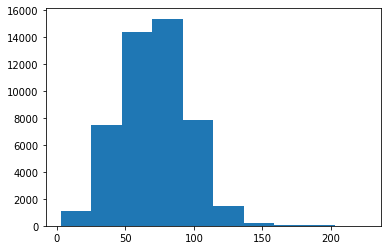

In [ ]:
import matplotlib.pyplot as plt
plt.hist(list(map(len, tokenized_texts)))
plt.show()

In [ ]:
# 입력 토큰의 최대 시퀀스 길이
MAX_LEN = 128

# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

input_ids[0]

array([   101,   9331, 119110,  20595,   9428,  41521,  12030,  24989,
         9202,  85297,  23545,   9202,  85297,  43022,  25387,   9318,
        10739,  90537,   9484,  12692,  14040,   9890, 118866,  28396,
         9881,  37824,   9485,  18784,   9978,  12508,   9484,  12692,
         9449,  30005,  70672,   9356,  12092,    102,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [ ]:
print(tokenizer.convert_ids_to_tokens(input_ids[0]))

['[CLS]', '백', '##악', '##관', '선', '##거', '##인', '##단', '로', '##이터', '미국', '로', '##이터', '##통', '##신', '바', '##이', '##든', '승', '##리', '##시', '트', '##럼', '##프', '투', '##표', '시', '##간', '현', '##지', '승', '##리', '속', '##보', '대통령', '보', '##도', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]'

In [ ]:
# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
# 훈련셋과 검증셋으로 분리
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,
                                                                                    labels, 
                                                                                    random_state=2020, 
                                                                                    test_size=0.1)

# 어텐션 마스크를 훈련셋과 검증셋으로 분리
train_masks, validation_masks, _, _ = train_test_split(attention_masks, 
                                                       input_ids,
                                                       random_state=2020,
                                                       test_size=0.1)

# 데이터를 파이토치의 텐서로 변환
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)				

print(train_inputs[0])
print(train_labels[0])
print(train_masks[0])
print(validation_inputs[0])
print(validation_labels[0])
print(validation_masks[0])

tensor([   101,   9365,  21386,   9460,  86834,  24017,   9812,  11261,  16439,
          9641,  16323,  18392,  18784,   9641,  16323,  18392,   9485,  86834,
         13890,   9485,  25242,  83811,  40311,   9651,  11287,  45465,  12692,
          9612,  45465,  15891,  26784,   9812,  11261,  16439,  54055,   9994,
         21386,  24982,   9953,  24017,  27023,   8907, 119081,  22333,    102,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0, 

In [ ]:
# 배치 사이즈
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

<br>
<br>

# **Preprocessing - TEST SET**

In [ ]:
# 리뷰 문장 추출
sentences = test['input']
sentences[:10]

31813    공무원 환경부 정부세종청사 코로나19 해양수산 세종청사 세종 확진자 청사 확진 정부...
52486    직불금 진천군 미이행 115억 만큼 공익적 서정배 코로나19 농업인 4차례 4500...
21498     코로나19 대유행 미국 확진자 코로나 소프트뱅크 유럽 팬데믹 금융위기 한국 반도체 각국
15145    충주 교통사고 교통질서 충주경찰서 시민들 교통문화 정재일 안전띠 수요일 이륜차안전모...
48009    백종원 소유진 맛남 유병재 용희 요섹남 서현 1남 물고추 다둥 이듬해 오른쪽 고춧가...
25169    기아차 중국 셀토스 1위 suv 자동차 쏘넷 기아자동차 영업이익 미국 4위 삼성증권 1인
7429     중국 추궈홍 비핵화 관련국 중국대사 전환기 김무성 미국 의원회관 한중 잠재력 김정은...
30971    외부인 코로나19 서울 코로나바이러스 연세대학교 안내문 신촌 대학가 감염증 서대문구...
12665    음악회 원어민교사 진천여중 주무관 수요일 교직원 학생들 데영 김희선 원어민 성원 관...
59504    경찰대 코로나19 한국 독일 금융사기 https 영국 성범죄 유튜브 코로나 홈페이지...
Name: input, dtype: object

In [ ]:
# BERT의 입력 형식에 맞게 변환
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
sentences[:10]

['[CLS] 공무원 환경부 정부세종청사 코로나19 해양수산 세종청사 세종 확진자 청사 확진 정부 국장 근무 폐쇄 판정 무더기 제외 전원 인원 귀가 필수 조치 [SEP]',
 '[CLS] 직불금 진천군 미이행 115억 만큼 공익적 서정배 코로나19 농업인 4차례 4500만 농가들 농업기술센터소장 진천 역진 지급 농가 단가 공익 미만 면적 [SEP]',
 '[CLS] 코로나19 대유행 미국 확진자 코로나 소프트뱅크 유럽 팬데믹 금융위기 한국 반도체 각국 [SEP]',
 '[CLS] 충주 교통사고 교통질서 충주경찰서 시민들 교통문화 정재일 안전띠 수요일 이륜차안전모 이륜차 70여 파출소 안전모 신호위반 법원사 음주운전 지구대 홍보활동 법원사거리 연말연시 교통경찰 10개소 첫날 교통 운전 운영 단속 사용 경찰 증가 정착 [SEP]',
 '[CLS] 백종원 소유진 맛남 유병재 용희 요섹남 서현 1남 물고추 다둥 이듬해 오른쪽 고춧가루 방송인 sbs 김치맛 방송화면 인스타그램 파김치 와이프 요리 방송 양파 섹시 중간 사진 아들 배우 광장 상식 아내 예능 슬하 [SEP]',
 '[CLS] 기아차 중국 셀토스 1위 suv 자동차 쏘넷 기아자동차 영업이익 미국 4위 삼성증권 1인 [SEP]',
 '[CLS] 중국 추궈홍 비핵화 관련국 중국대사 전환기 김무성 미국 의원회관 한중 잠재력 김정은 지도자 서울 [SEP]',
 '[CLS] 외부인 코로나19 서울 코로나바이러스 연세대학교 안내문 신촌 대학가 감염증 서대문구 출입 신종 캠퍼스 중심 감염 예방 설치 [SEP]',
 '[CLS] 음악회 원어민교사 진천여중 주무관 수요일 교직원 학생들 데영 김희선 원어민 성원 관객들 연주자 시청각실 등대지기 알레드 로렌 이너프 권진아 삽입곡 쇼맨 댄스무대 댄스팀 해금 양승준 시설관리주무관 학교구성원들 감동적 최경희 구성원 콜라보 7회 성료 진천여 제7회 deyoung [SEP]',
 '[CLS] 경찰대 코로나19 한국 독일 금융사기 https 영국 성범죄 유튜브 코로나 홈페이지 국제학술세미나

In [ ]:
# 라벨 추출
labels = test['label'].values
labels

array([ 9, 43, 47, ..., 61, 60, 15])

In [ ]:
# BERT의 토크나이저로 문장을 토큰으로 분리
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

print (sentences[0])
print (tokenized_texts[0])

[CLS] 공무원 환경부 정부세종청사 코로나19 해양수산 세종청사 세종 확진자 청사 확진 정부 국장 근무 폐쇄 판정 무더기 제외 전원 인원 귀가 필수 조치 [SEP]
['[CLS]', '공', '##무', '##원', '환', '##경', '##부', '정', '##부', '##세', '##종', '##청', '##사', '코', '##로', '##나', '##19', '해', '##양', '##수', '##산', '세', '##종', '##청', '##사', '세', '##종', '확', '##진', '##자', '청', '##사', '확', '##진', '정', '##부', '국', '##장', '근', '##무', '폐', '##쇄', '판', '##정', '무', '##더', '##기', '제', '##외', '전', '##원', '인', '##원', '귀', '##가', '필', '##수', '조', '##치', '[SEP]']


In [ ]:
# 입력 토큰의 최대 시퀀스 길이
MAX_LEN = 128

# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

input_ids[0]

array([   101,   8896,  32537,  14279,   9995,  31720,  14646,   9670,
        14646,  24982,  22200,  40311,  12945,   9812,  11261,  16439,
        54055,   9960,  37114,  15891,  21386,   9435,  22200,  40311,
        12945,   9435,  22200,   9994,  18623,  13764,   9751,  12945,
         9994,  18623,   9670,  14646,   8909,  13890,   8926,  32537,
         9927, 119058,   9903,  16605,   9294,  54141,  12310,   9672,
        78705,   9665,  14279,   9640,  14279,   8920,  11287,   9949,
        15891,   9678,  18622,    102,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [ ]:
# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
# 데이터를 파이토치의 텐서로 변환
test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

print(test_inputs[0])
print(test_labels[0])
print(test_masks[0])

tensor([   101,   8896,  32537,  14279,   9995,  31720,  14646,   9670,  14646,
         24982,  22200,  40311,  12945,   9812,  11261,  16439,  54055,   9960,
         37114,  15891,  21386,   9435,  22200,  40311,  12945,   9435,  22200,
          9994,  18623,  13764,   9751,  12945,   9994,  18623,   9670,  14646,
          8909,  13890,   8926,  32537,   9927, 119058,   9903,  16605,   9294,
         54141,  12310,   9672,  78705,   9665,  14279,   9640,  14279,   8920,
         11287,   9949,  15891,   9678,  18622,    102,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0, 

In [ ]:
# 배치 사이즈
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

<br>
<br>

# **MODEL Initialization**

In [ ]:
# GPU 디바이스 이름 구함
device_name = tf.test.gpu_device_name()

# GPU 디바이스 이름 검사
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
# 디바이스 설정
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB


In [ ]:
# 분류를 위한 BERT 모델 생성
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=NUM_LABELS)
model.cuda()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
# 옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

# 에폭수
epochs = 30

# 총 훈련 스텝 : 배치반복 횟수 * 에폭
total_steps = len(train_dataloader) * epochs

# 처음에 학습률을 조금씩 변화시키는 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

<br>
<br>

# **MODEL Training**

In [ ]:
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
from time import gmtime, strftime
START_TIME = strftime("%Y_%m_%d_%H_%M_%S", gmtime())

In [ ]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

model.zero_grad()

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()
        
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # Forward 수행                
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # 로스 구함
        loss = outputs[0]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
    
    PATH = BASE_URL+"/bert_news_model_{}.pth".format(START_TIME)
    torch.save(model.state_dict(), PATH)
    print("  Model saved at {}".format(PATH))
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        
        # 그래디언트 계산 안함
        with torch.no_grad():     
            # Forward 수행
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # 로스 구함
        logits = outputs[0]

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 30 ========
Training...
  Batch   500  of  1,350.    Elapsed: 0:01:58.
  Batch 1,000  of  1,350.    Elapsed: 0:03:56.

  Average training loss: 2.83
  Training epcoh took: 0:05:19
  Model saved at /content/drive/MyDrive/hu_dataset/bert_news_model_2020_11_30_05_09_26.pth

Running Validation...
  Accuracy: 0.43
  Validation took: 0:00:10

======== Epoch 2 / 30 ========
Training...
  Batch   500  of  1,350.    Elapsed: 0:01:58.
  Batch 1,000  of  1,350.    Elapsed: 0:03:56.

  Average training loss: 2.06
  Training epcoh took: 0:05:18
  Model saved at /content/drive/MyDrive/hu_dataset/bert_news_model_2020_11_30_05_09_26.pth

Running Validation...
  Accuracy: 0.51
  Validation took: 0:00:10

======== Epoch 3 / 30 ========
Training...
  Batch   500  of  1,350.    Elapsed: 0:01:58.
  Batch 1,000  of  1,350.    Elapsed: 0:03:56.

  Average training loss: 1.72
  Training epcoh took: 0:05:19
  Model saved at /content/drive/MyDrive/hu_dataset/bert_news_model_2020_11_30_05_09_

#**Load Model**

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=NUM_LABELS)
model.cuda()
model.load_state_dict(torch.load(PATH))
model.eval()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

<br>
<br>

# **Test Set Evaluation**

In [ ]:
#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_dataloader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)
    
    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch
    
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))

  Batch   100  of    375.    Elapsed: 0:00:07.
  Batch   200  of    375.    Elapsed: 0:00:13.
  Batch   300  of    375.    Elapsed: 0:00:20.

Accuracy: 0.58
Test took: 0:00:25


<br>
<br>

# **NEW topic Test**

In [ ]:
# 입력 데이터 변환
def convert_input_data(sentences):

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이
    MAX_LEN = 128

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    
    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

In [ ]:
# 문장 테스트
def test_sentences(sentences):

    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
            
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()

    return logits

In [ ]:
logits = test_sentences(['경찰 무력 시위 강압 폭행'])

print(logits)
print(np.argmax(logits))


[[-0.5553014   1.1636798   4.331775    0.284531    0.701762    0.18182372
  -0.81259525 -0.6040593   0.73273855 -0.07076877  0.05800076  1.6265992
  -0.6516759  -0.79124063  1.6689017  -1.013213    1.4717002  -0.16425364
  -0.93220574 -0.31989643  1.8041921  -0.4293834  -1.014419   -1.1526823
  -0.63746774 -1.6706144  -0.03637895  0.14784603  0.76720166 -0.43307778
  -0.7251667  -0.48204148 -0.2615093  -0.17751452 -0.7837909  -0.83278006
  -1.6937932  -0.64513594 -0.4853816   3.1254256  -0.17023526 -0.5775923
   0.06924354  0.65088516 -0.319876   -0.8639546   0.2839826  -0.2693283
   0.29786462 -1.0309901  -0.38604105 -0.8095653   0.3269498  -0.04358091
  -0.6004411  -0.7257758   0.9699153   0.66252625 -0.15584436  0.01081265
  -0.44517967 -0.8007265   0.24600221 -1.0492593   0.28927797 -0.32362634
  -0.60572743 -0.59088296 -0.97560203 -0.21741377 -0.13653731 -1.0215555
  -0.14815433 -1.2362684  -0.47499362 -0.8426772   0.5446229   0.16645676
  -0.9795745  -0.68315876 -0.6824562  -0.53